In [4]:
# Inicialização

import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import serial
import time
import scipy.signal as sig
import pandas as pd

from matplotlib import animation, rc
from IPython.display import HTML

import scipy.optimize as opt

%matplotlib notebook

In [5]:
# CALIBRACAO

FinalPix = np.array([ 31, 54, 76, 113, 151, 171,190,197,205, 258,226,236]) # pixeis para o ajuste
FinalWav = np.array((388.86,447.14,501.56,587.56,667.81,706.51,738.4,750.93,763.51,842,801,811)) # wavelenghts
deg= 5 # 5º grau dá bons resultados

aj= np.polyfit(FinalPix,FinalWav,deg)[::-1]
ajFinal = np.polynomial.polynomial.Polynomial( aj )


In [6]:
# DEFINICAO DO METODO

# Load dos dados para a biblioteca
lib = [[]]

X= np.loadtxt("Data/1hg.txt", delimiter=";")
indexInt = np.where(X[1] > 100)[0] # Limitar as intensidade, so queremos picos acima de certa intensidade
lib[0] = X[0][indexInt]
X = np.loadtxt("Data/2he.txt",delimiter=";")
indexInt = np.where(X[1] > 200)[0]
lib.append(X[0][indexInt])
X = np.loadtxt("Data/3ne.txt",delimiter=";")
X = np.loadtxt("Data/4kr.txt",delimiter=";")
indexInt = np.where(X[1] > 200)[0]
lib.append(X[0][indexInt])
X = np.loadtxt("Data/5ar.txt",delimiter=";")
indexInt = np.where(X[1] > 200)[0]
lib.append(X[0][indexInt])


def identify(inputSignalWavelenght,inputSignalIntensity,elementLib):
    # Some important constants
    delta = 2 # Possible error on wavelenght to still consider a hit
    
    # Find the peaks
    indexMaximum = sig.find_peaks(inputSignalIntensity, prominence = 25)
    
    # Array to save confidence
    confidence = []
    
    # Search for elements
    for element in elementLib:
        hits = 0
        for i in indexMaximum[0]:
            minWav = inputSignalWavelenght[i] - delta
            maxWav = minWav + 2*delta
            #print("i")
            #print(inputSignalWavelenght[i])
            for val in element:
                #print(val)
                if minWav <= val and val <= maxWav:
                    hits += 1
                    break
        confidence.append(hits / len(element))
        
    result = confidence.index(max(confidence))
    
    return confidence

pix = np.arange(0,288)
wav = ajFinal(pix)

O método retorna uma matriz com os valores de confiança da presença de cada elemento, sendo os elementos, por ordem, Mercúrio, Hélio, Néon, Kripton, Árgon. O valor da confiança mais alta é o que ele acha que é.

In [7]:
valHelio = np.loadtxt("Data/Helio") # Load do exemplo do hélio

conf = identify(wav,valHelio,lib)
print(conf)
maxi = np.argmax(conf)

if maxi == 0:
    print("Mercúrio")
elif maxi == 1:
    print("Hélio")
elif maxi == 2:
    print("Néon")
elif maxi == 3:
    print("Kripton")
elif maxi == 4:
    print("Árgon")

[0.0, 1.0, 0.0, 0.07692307692307693]
Hélio


# Medição em tempo real
ATENÇÃO!!! Só correr com o espectrómetro ligado, caso contrário dá erro. Para interromper, interroper a célula

<IPython.core.display.Javascript object>


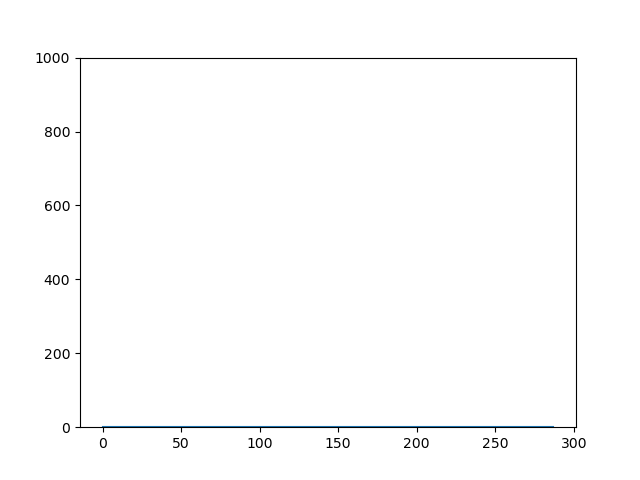

Hélio        

KeyboardInterrupt: 

In [16]:
ser = serial.Serial('/dev/ttyUSB0',115200)

spec =288

pix= np.arange(0,288)

# Make sure to clear serial backlog
ser.flushInput()
ser.readline()
ser.readline()

fig = plt.figure()
ax = fig.add_subplot(111)

plt.ion()

plt.xlim(340,850)


fig.show()
fig.canvas.draw()

# Draw graph
while(True):
    # Get values
    b = ser.readline()
    string_n = b.decode()
    string = string_n.rstrip()
    val = list(map(int,string[0:-1].split(',')))
    
    # Draw graph
    ax.clear()
    ax.set_ylim(0,1000)
    ax.plot(pix,val)
    fig.canvas.draw()
    
    conf = identify(wav,valHelio,lib)
    maxi = np.argmax(conf)

    if maxi == 0:
        print("\r             ",end="") #Clear
        print("\rMercúrio",end="")
    elif maxi == 1:
        print("\r             ",end="")
        print("\rHélio",end="")
    elif maxi == 2:
        print("\r             ",end="")
        print("\rNéon",end="")
    elif maxi == 3:
        print("\r             ",end="")
        print("\rKripton",end="")
    elif maxi == 4:
        print("\r             ",end="")
        print("\rÁrgon",end="")
    